In [1]:
# coding: utf-8

from pysap.plugins.mri.reconstruct_3D.fourier import NUFFT, NFFT3, FFT3
from pysap.plugins.mri.reconstruct.fourier import NFFT2, FFT2

import numpy as np
from pysap.plugins.mri.reconstruct_3D.utils import convert_mask_to_locations_3D
from pysap.plugins.mri.reconstruct.utils import convert_mask_to_locations
from modopt.math.metrics import mse
import matplotlib.pyplot as plt
from pysap.plugins.mri.parallel_mri.extract_sensitivity_maps import gridding_nd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

/home/bs255482/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@gmail.com>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

matplotlib     : >=2.1.2   - required | 2.2.2     installed
progressbar    : >=3.34.3  - required | 3.37.1    installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
modopt         : >=1.1.4   - required | 1.1.5     installed
nibabel        : >=2.1.0   - required | 2.2.1     installed
scipy          : >=1.0.0   - required | 1.1.0     installed
future         : >=0.16.0  - required | 0.16.0    installed
pysparse       : >=0.0.1   - required | 0.0.1     installed
astropy        : ==2.0.4   - re

In [2]:
_mask = np.ones(np.random.randint(2, size=(512, 512)).shape)
_samples = convert_mask_to_locations(_mask)
_samples_shift = convert_mask_to_locations(np.fft.fftshift(_mask))
images = np.load('/volatile/bsarthou/datas/NUFFT/mri_img_2D.npy')

In [3]:
fourier_op_dir_nufft = NUFFT(samples=_samples, platform='cpu',
                             shape=(512, 512), Kd=512, Jd=3)
fourier_op_dir_nfft = NFFT2(samples=_samples, shape=(512, 512))

fourier_op_dir_fft = FFT2(samples=_samples_shift, shape=(512, 512))

Creating the NUFFT object...


In [4]:
kspace_nfft = fourier_op_dir_nfft.op(images)
kspace_nufft = fourier_op_dir_nufft.op(images)
kspace_fft = np.fft.ifftshift(fourier_op_dir_fft.op(np.fft.fftshift(images)))
kspace_fft = kspace_fft.flatten()/np.sqrt(512*512)

In [5]:
# In[22]:
print('NUFFT VS NFFT: ', mse(kspace_nufft, kspace_nfft))
print('NUFFT VS FFT: ', mse(kspace_nufft, kspace_fft))
print('NFFT VS FFT: ', mse(kspace_nfft, kspace_fft))

NUFFT VS NFFT:  2.1820673435658154e-08
NUFFT VS FFT:  2.182067343565914e-08
NFFT VS FFT:  3.3216162877775056e-33


In [6]:
# 3D plot
print("regridding")
k_space_fft_3D = gridding_nd(_samples_shift, kspace_fft, (512, 512))
k_space_nfft_3D = gridding_nd(_samples, kspace_nfft, (512, 512))
k_space_nufft_3D = gridding_nd(_samples, kspace_nufft, (512, 512))
print('regridding done')

regridding
(262144, 2)
(262144,)
(262144, 2)
(262144,)
(262144, 2)
(262144,)
regridding done


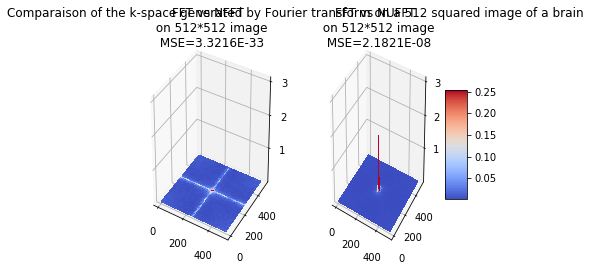

In [13]:
fig = plt.figure()
fig.suptitle('Comparaison of the k-space generated by Fourier transform on a 512 squared image of a brain')
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d', sharez=ax1)

X, Y = np.meshgrid(np.arange(k_space_fft_3D.shape[0]),
                   np.arange(k_space_fft_3D.shape[1]))
ax1.set_title('FFT vs NFFT \n on 512*512 image\n MSE={:.4E}'.format(mse(kspace_nfft, kspace_fft)))
ax1.plot_surface(X, Y, np.abs(k_space_fft_3D-k_space_nfft_3D),
                 cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax2.set_title('FFT vs NUFFT \n on 512*512 image\n MSE={:.4E}'.format(mse(kspace_nufft, kspace_fft)))
surf = ax2.plot_surface(X, Y, np.abs(k_space_fft_3D-k_space_nufft_3D),
                        cmap=cm.coolwarm,
                        linewidth=0, antialiased=False)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()